In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install kaggle

In [0]:
!mkdir kaggle

In [0]:
import json
token = {"username":"debparna96","key":"9e6f845feeedb01af38c656f7c57261a"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d jdpaletto/glove-global-vectors-for-word-representation

100% 1.45G/1.45G [00:38<00:00, 37.9MB/s]
100% 1.45G/1.45G [00:38<00:00, 40.7MB/s]


In [12]:
!unzip {/content}/datasets/jdpaletto/glove-global-vectors-for-word-representation/glove-global-vectors-for-word-representation.zip

Archive:  {/content}/datasets/jdpaletto/glove-global-vectors-for-word-representation/glove-global-vectors-for-word-representation.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


## ChatBot prototype

In [13]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 25 
 glove.twitter.27B.25d.txt
[i] Importing Modules...


Using TensorFlow backend.


[+] Using Keras version 2.2.5
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (30057, 30)
[+] Shape of label tensor: (30057, 41)
[i] Number of entries in each category:
[+] Training:
 [1248. 1242. 1584.  284.  480. 1708.  324.  306.  482.    7. 1465. 1439.
 1202.  957.  411.  410.  160.  324. 1369.  626.  397.  389. 1210.  318.
 1277.  734.  692. 2039.   10.   10.   17.   17.  631.   33.   41.   10.
   18.   24.   17.  116.   18.]
[+] Validation:
 [300. 308. 416.  76. 120. 392.  77.  94. 118.   2. 359. 361. 298. 243.
  89.  90.  40.  77. 345. 176. 103. 111. 290.  82. 352. 187. 159. 481.
   2.   6.   3.   3. 169.  12.  10.   3.   2.   8.  12.  25.  10.]
[i] Loading GloVe from: glove.twitter.27B.25d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [14]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [15]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [16]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [0]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [19]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(41, activation='softmax')(l_dense)

In [20]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [0]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [0]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [24]:
model.summary()
model.save('BalanceNet.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 25)       859000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 25)       859000      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       1536        embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
model = keras.models.load_model("checkpoint-0.91.h5")

Time to train!!

In [25]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=200, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 24046 samples, validate on 6011 samples


Epoch 1/200
24046/24046 [==============================] - 167s 7ms/step - loss: 2.7329 - acc: 0.2449 - val_loss: 1.8034 - val_acc: 0.4780

Epoch 2/200
24046/24046 [==============================] - 156s 7ms/step - loss: 1.5757 - acc: 0.5084 - val_loss: 1.1801 - val_acc: 0.6262
Epoch 3/200
24046/24046 [==============================] - 152s 6ms/step - loss: 1.1854 - acc: 0.6090 - val_loss: 0.9138 - val_acc: 0.7107
Epoch 4/200
24046/24046 [==============================] - 149s 6ms/step - loss: 0.9827 - acc: 0.6688 - val_loss: 0.7702 - val_acc: 0.7596
Epoch 5/200
24046/24046 [==============================] - 148s 6ms/step - loss: 0.8658 - acc: 0.7037 - val_loss: 0.6774 - val_acc: 0.7854
Epoch 6/200
24046/24046 [==============================] - 150s 6ms/step - loss: 0.7802 - acc: 0.7344 - val_loss: 0.6165 - val_acc: 0.7964

KeyboardInterrupt: ignored

## Model Testing and Inference

In [0]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ['Banking_Activate_Card', 'Banking_Cancel_Card', 'Banking_Card_Request', 'Banking_Change_Address', 'Banking_Change_Contact', 'Banking_Change_Credential_Info', 'Banking_Change_Passcode', 'Banking_Change_Password', 'Banking_Change_Username', 'Banking_Email', 'Banking_Fee_Inquiry', 'Banking_Get_Acc_Status', 'Banking_Get_Account_Balance', 'Banking_Get_Account_Details', 'Banking_Get_Account_Number', 'Banking_Get_Address',  'Banking_Get_Card_Details', 'Banking_Get_Card_Number', 'Banking_Get_Card_Request_Status', 'Banking_Get_Card_Status', 'Banking_Get_Contact', 'Banking_Get_Email', 'Banking_Get_Secure_Info', 'Banking_Get_Username', 'Banking_Replace_Card', 'Banking_Report_Missing_Card', 'Banking_Transfer_Money', 'Banking_View_Activity', 'Bot_Control_Change_Subject', 'Bot_Control_Confirm_Presence', 'Bot_Control_Standby', 'Bot_Control_Start_Over', 'Bot_Desc', 'General_Ending', 'General_Greetings', 'General_Human_or_Bot', 'General_Negative_Feedback', 'General_Positive_Feedback', 'General_Security_Assurance', 'affirm', 'deny']

In [27]:
! ls

'{'		       data.csv			    kaggle
 BalanceNet.h5	       drive			    logs
 checkpoint-0.287.h5   ExtraFunctions.ipynb	    sample_data
 checkpoint-0.290.h5   glove.twitter.27B.100d.txt   Setup.ipynb
 checkpoint-0.295.h5   glove.twitter.27B.200d.txt   tokenizer.pickle
 checkpoint-0.297.h5   glove.twitter.27B.25d.txt
 checkpoint-0.305.h5   glove.twitter.27B.50d.txt


In [0]:
#model_test = load_model('checkpoint-0.866.h5')
model_test = load_model('checkpoint-0.364.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [72]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

                                 precision    recall  f1-score   support

          Banking_Activate_Card       0.71      0.48      0.57       300
            Banking_Cancel_Card       0.68      0.80      0.74       308
           Banking_Card_Request       0.97      0.96      0.96       416
         Banking_Change_Address       0.71      0.83      0.76        76
         Banking_Change_Contact       0.91      0.96      0.93       120
 Banking_Change_Credential_Info       0.80      0.79      0.79       392
        Banking_Change_Passcode       0.81      0.78      0.79        77
        Banking_Change_Password       0.61      0.71      0.66        94
        Banking_Change_Username       0.83      1.00      0.91       118
                  Banking_Email       0.00      0.00      0.00         2
            Banking_Fee_Inquiry       0.96      0.99      0.98       359
         Banking_Get_Acc_Status       0.98      1.00      0.99       361
    Banking_Get_Account_Balance       0.95      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


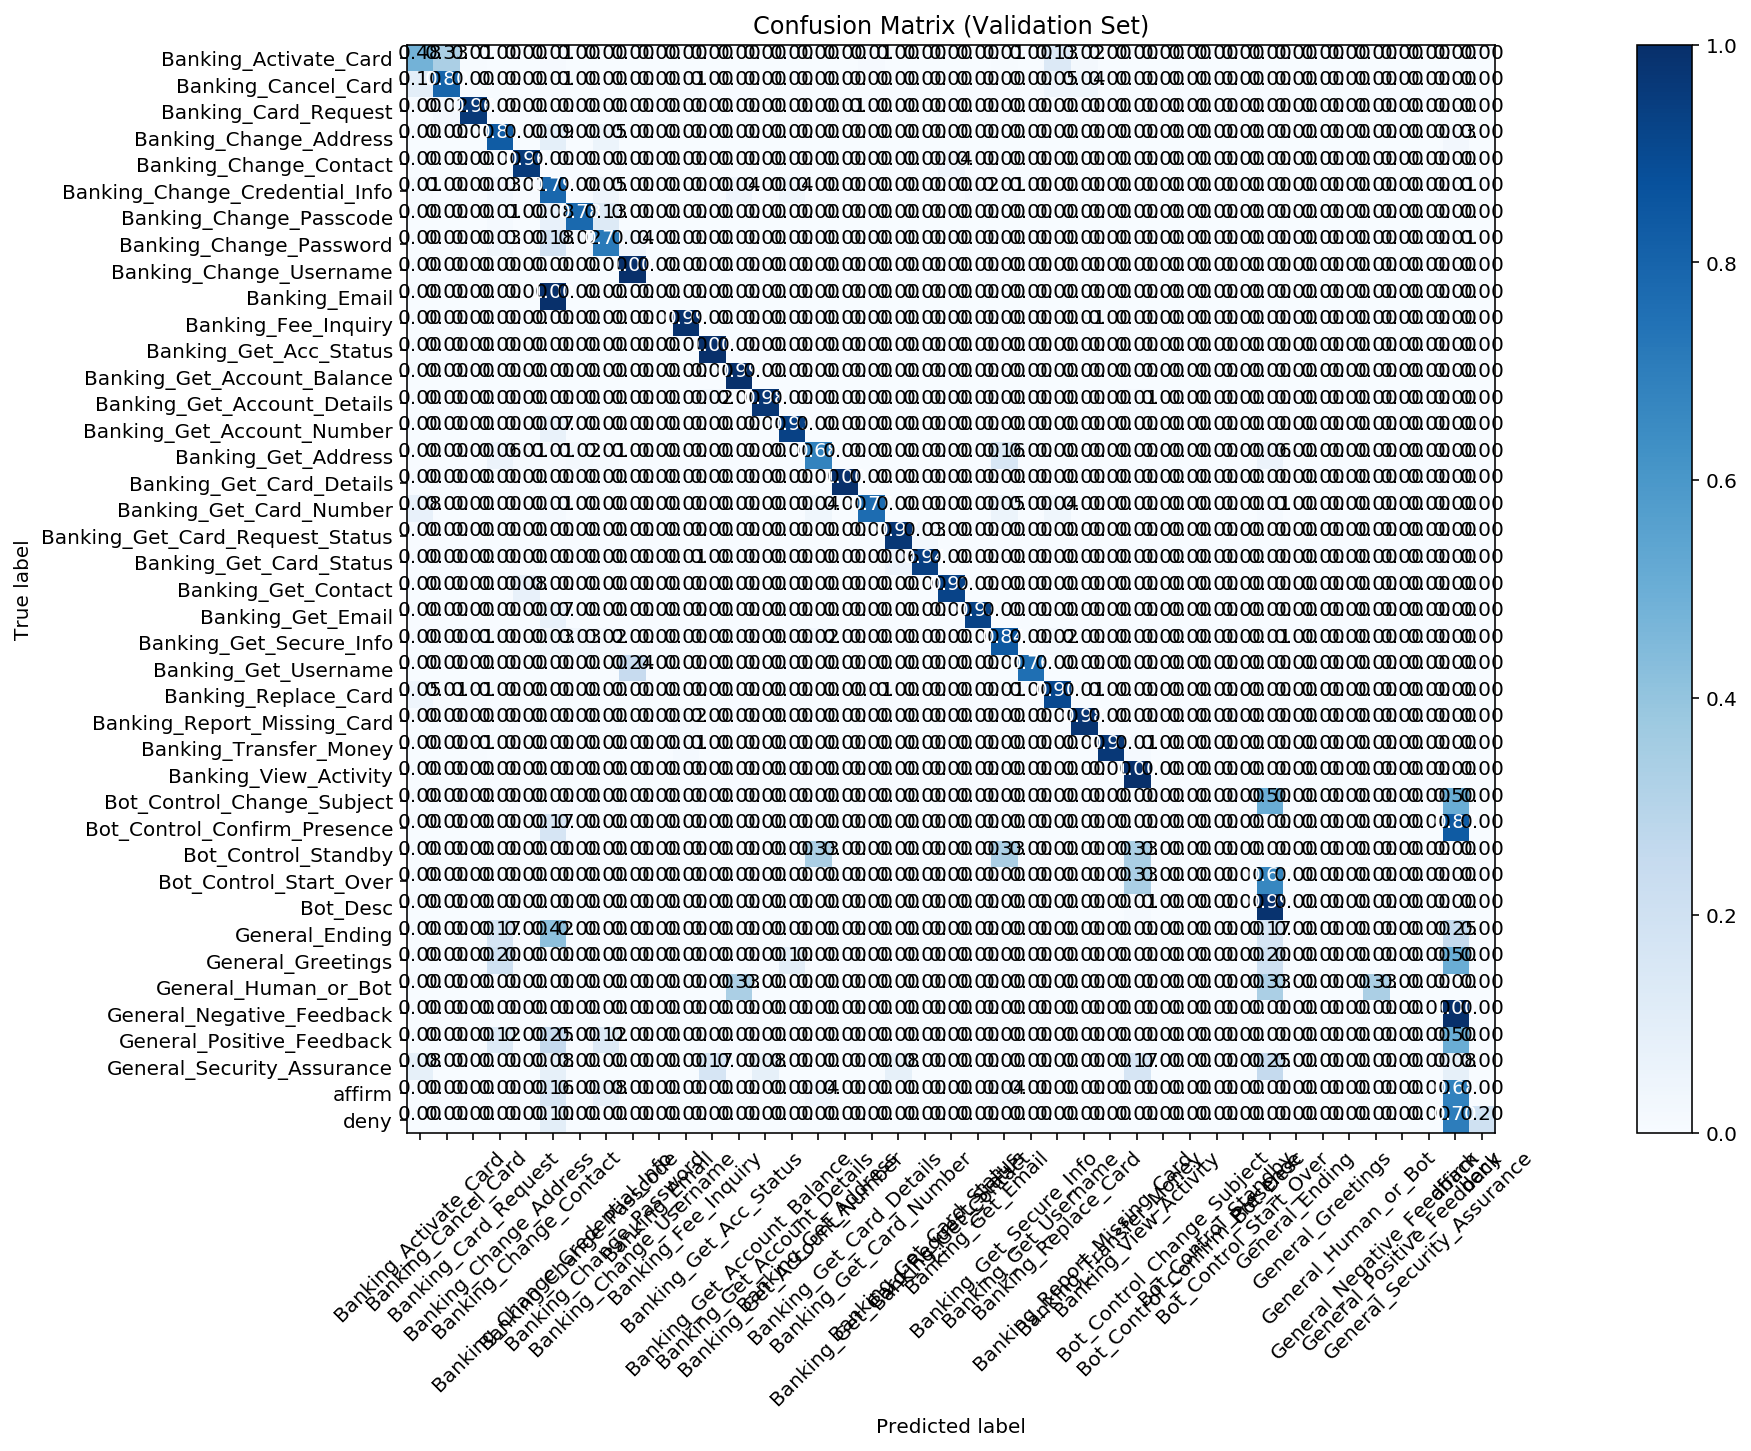

In [73]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [0]:
MAX_SEQUENCE_LENGTH = 30

In [74]:
text = ["I want to change password",
        "","","","",""]

sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")
    break

I want to change password 
Prediction: Banking_Change_Username 



### **Extra--------------------------**

In [0]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: sad 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: hate 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: sad 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: sad 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: sad 



In [0]:
np.array(sequences_test[0])

array([   1, 6097,    5,   12,    3,    6, 4841,    4,  515, 1476, 1238])